## Analisis sismico en colombia atravez de estadistica descriptiva

<div style="text-align: right"> Elaborado por: Edgar Barahona </div>
<div style="text-align: right"> Ingeniero Catastral y Geodesta </div>
<div style="text-align: right"> Universidad Distrital Francisco Jose de Caldas </div>
<div style="text-align: right"> Bogota, D.C., 20 de Febrero de 2023</div>
<div style="text-align: right"> puede revisar el <a href="https://github.com/EDGAR-BARAHONA?tab=repositories">Repositorio GitHub</a> para mas  </div>

La sismicidad es uno de los fenomenos mas interesantes y peligrosos en la naturaleza, por lo cual merece dedicarle ua analisis para identificar aspectos que pueden ser de interes y que peuden ser derivadosa de los datos capturados por sismografos a nivel Nacional. Para este análisis usaremos datos provenientes del sistema nacional de sismografos de  Colombia los cuales pueden ser obtenidos  de la pagina del [Servicio Geologico Colombiano (SGC)](http://bdrsnc.sgc.gov.co/paginas1/catalogo/index.php); en este catalogo se  almacenan registro referidos a la magnitud local de los eventos sismicos ocurridos en la nacion.

En este caso se aplicara un anañisis estadistico simple, aplicanco estadistica descriptiva, ello con la finalida de poder identificar aspectos de valor en los datos que nos ayuden a entender un poco mejor el fenomeno de interes.

In [291]:
import glob
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go

Como siempre iniciaremos cargando las librerias que usaremos a lo largo del proceso.

### Estrcturación del dataset de sismos

El primer paso del analisis consiste en generar un solo elemento que contenga la totalidad de los registro relacionados a la sismicidad, ello dado a que el catalogo se encuentra dividido en varios archivos, para ello, leeremos la totalidad de archivos que contengan una extension **.xlsx.**, los nombres de tales archivos seran almacenados en una lista, luego usando un ciclo for adicionaremos cada uno de los contenidos del archivo a un unico dataframe llamado **sismos**

In [292]:
path = "Datos"
 
Archivos = glob.glob(path + "/*.xlsx")
ListaExcel = []
 
for Archivo in Archivos:
    ListaExcel.append(pd.read_excel(Archivo))
 
sismos = pd.DataFrame() 
for excel in ListaExcel:
    sismos = sismos.append(
      excel, ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9928\2472829785.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Ahora veamos la estructura que contiene el dataframe de sismos creado con anterioridad.

In [293]:
sismos.head(3)

,FECHA,HORA_UTC,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,MAGNITUD Mw,DEPARTAMENTO,MUNICIPIO,# FASES,RMS (Seg),GAP (grados),ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),ESTADO
0,1993-06-01,01:32:55,6.795,-73.052,150.1,2.9,NaN,SANTANDER,LOS_SANTOS,4,0.3,320.0,8.7,10.0,8.6,Revisado
1,1993-06-01,03:08:28,6.790,-73.053,152.5,3.0,NaN,SANTANDER,LOS_SANTOS,4,0.3,320.0,10.3,9.8,8.9,Revisado
2,1993-06-01,10:13:18,6.839,-73.105,152.1,2.9,NaN,SANTANDER,LOS_SANTOS,4,0.5,321.0,13.2,12.3,11.2,Revisado


Lo siguiente sera validar el total de columnas y registros que contiene el dataframe y su tipo, ello con la finalidad de identificar aspectos de relevancia para el proceso.

In [294]:
"El numero de variables en el catalogo es de "+str(len(sismos.dtypes)) + ", el catalogo contiene un total de "+ str(len(sismos))+ " registros"

'El numero de variables en el catalogo es de 16, el catalogo contiene un total de 176379 registros'

In [295]:
sismos.columns

Index(['FECHA', 'HORA_UTC', 'LATITUD (grados)', 'LONGITUD (grados)',
       'PROFUNDIDAD (Km)', 'MAGNITUD Ml', 'MAGNITUD Mw', 'DEPARTAMENTO',
       'MUNICIPIO', '# FASES', 'RMS (Seg)', 'GAP (grados)',
       'ERROR LATITUD (Km)', 'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)',
       'ESTADO'],
      dtype='object')

In [296]:
sismos.dtypes

FECHA                      object
HORA_UTC                   object
LATITUD (grados)          float64
LONGITUD (grados)         float64
PROFUNDIDAD (Km)          float64
MAGNITUD Ml               float64
MAGNITUD Mw               float64
DEPARTAMENTO               object
MUNICIPIO                  object
# FASES                     int64
RMS (Seg)                 float64
GAP (grados)              float64
ERROR LATITUD (Km)        float64
ERROR LONGITUD (Km)       float64
ERROR PROFUNDIDAD (Km)    float64
ESTADO                     object
dtype: object

In [297]:
sismos.isna().sum()

FECHA                          0
HORA_UTC                       0
LATITUD (grados)               0
LONGITUD (grados)              0
PROFUNDIDAD (Km)               0
MAGNITUD Ml                    0
MAGNITUD Mw               171771
DEPARTAMENTO                   0
MUNICIPIO                      0
# FASES                        0
RMS (Seg)                    189
GAP (grados)                 189
ERROR LATITUD (Km)           189
ERROR LONGITUD (Km)          189
ERROR PROFUNDIDAD (Km)       189
ESTADO                         0
dtype: int64

Como se puede ver, los datos asociados a la red sismografica nacional contiene en total 16 variables, de las cuales la variable **MAGNITUD Mw (Magnitud de momento)** se encuentra vacia casi en la totalidad de sus registros. En general se identifica que la totalidad de registros es de 176379, eventos y el numero de variables que tiene el catalogo de sismos es de 16., la descipciónde las varaibles del catalogo se muestran acontinuación.

    - FECHA: Fecha de ocurrencia del sismo
    - HORA_UTC: Hora UTC de la ocurrencia del sismo
    - LATITUD (grados): Latitud en grados de la ocurrencia del sismo
    - LONGITUD (grados): Longitud en grados de la ocurrencia del sismo
    - PROFUNDIDAD (Km): profundidad en km de la ocurrencia del sismo
    - MAGNITUD Ml: Magnitud local del sismo ocurrido
    - MAGNITUD Mw: Magnitud de momento del sismo ocurrido       
    - DEPARTAMENTO: Departamento donde ocurrio el sismo
    - MUNICIPIO: Municipio donde ocurrio el sismo
    - #_FASES: Numero de fases del sismo
    - RMS (Seg): eror der ajuste en los tiempos de llegada de las ondas en un modelo y la realidad
    - GAP (grados): Angulo de llegada
    - ERROR LATITUD (Km): Error de latitud medidad en km
    - ERROR LONGITUD (Km): Error de longitud medidad en km
    - ERROR PROFUNDIDAD (Km): erro de profundadidad en km
    - ESTADO: Estado de la medición.

### Enriquecimiento del dataset de sismos

Identificados aspectos claves de la estructura de los datos el siguiente paso se centrara en tratar los datos del catalogo de sismicidad, esto para obtener valores que nos sean de interes. Estos procesos se centran en el tratamieno de las variables existentes y el enriquecimiento de los datos a partir de información espacial que es de interes y que se espera ayude a describir de una forma mas detallada el proceso analizado. En primer caso cargaremos una serie de archivos shapefiles que son descritos aconitnuación y para ellos usaremos la libreria [Geopandas](https://geopandas.org/en/stable/docs/reference/api/geopandas.sindex.SpatialIndex.nearest.html).


1) Departaqmentos: Shapefile de departamentos del [marco geografico nacional](https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/descarga-mgn-marco-geoestadistico-nacional/) del DANE.
2) Unidades Cronoestatigraficas: Shapefile de unidades cronoestatigraficas de colombia, Creado en el [mapa geologico nacional](https://www2.sgc.gov.co/MGC/Paginas/mgc_1M2020.aspx) del servicio geologico colombiano.
3) Fallas Geologicas de colombia, Creado en el [mapa geologico nacional](https://www2.sgc.gov.co/MGC/Paginas/mgc_1M2020.aspx) del servicio
3) Volcanes de colombia, Creado en el [mapa geologico nacional](https://www2.sgc.gov.co/MGC/Paginas/mgc_1M2020.aspx) del servicio 

Una vez cargados los elementos estos son tranformados del sistema de coordenadas que contiene a el sistema geocentrico WGS84.

In [298]:
Departamento = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/MGN_DPTO_POLITICO.shp')
unidades_crono = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/UnidaddesCrono.shp')
fallas = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/Fallas.shp')
Volcanes = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/Volcanes.shp')


unidades_crono = unidades_crono.to_crs("epsg:4326")
fallas = fallas.to_crs("epsg:4326")
Volcanes = Volcanes.to_crs("epsg:4326")

El siguiente paso se centra en el enriqueciomiento de los datos usando el shapefile de Departamentos; ello con la finalidad de obtener el area por departamento. Para este enriquecimiento primero es necesario aplicar una nornalización a los nombre de los departamentos, estos se hace con la finalidad de capitalizar los nombres del archivo para que estos sean concordantes con los nombre de los departamentos en el catalogo de sismos. Junto a este proceso de normalización se realiza un proceso de ajuste en el nombre del departamento de San Andres tranformado este de *ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA* a *ARCHIPIELAGO DE SAN ANDRES. PROV. Y STA CATALINA*.

In [299]:
Departamento.DPTO_CNMBR = Departamento.DPTO_CNMBR.astype("category")
Departamento.DPTO_CNMBR = Departamento.DPTO_CNMBR.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
rename_dic = {"ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA":"ARCHIPIELAGO DE SAN ANDRES. PROV. Y STA CATALINA"}
Departamento.DPTO_CNMBR = Departamento.DPTO_CNMBR.replace(rename_dic).astype("category")

Una vez se normaliza el shapefile de departamentos, se realiza un merge usando este ultimo junto a el catalogo de sismos usanod la función *merge* de la libreria pandas.

In [300]:
sismos.DEPARTAMENTO = sismos.DEPARTAMENTO.astype("category")
sismos = pd.merge(sismos, Departamento[['DPTO_CNMBR',"DPTO_NAREA"]], left_on = 'DEPARTAMENTO', right_on='DPTO_CNMBR', how="left")

Una vez terminado este paso, el siguiente paso se centra en el enriquecimiento de el catalogo usando las capas mencionadas y que no hemos implementado. En este caso para en enriquecimiento de datos usaremos un proceso conocido como *UNION ESPACIAL* o *SPATIAL JOIN* el cual es uin tipo de unión en el cual el resultado de los elementos unidos esta en función de la relación espacial (topologia) existente entre la capas intersectadas (*fallas, volcanes y unidades cronoestatigraficas*) y la capa de destino que en este caso es el catalogo de sismos.

La siguiente imagen describe  el proceso, la idea es adicionar variables de interes en función de la posicón espacial de cada sismo y su relacion espcial con las capas mencionadas

<figure align = "center">
<img src='Datos/SpatialJoin.png' alt="sssss">
<figcaption style="text-align:center;">
<a href="https://gisgeography.com/spatial-join/">Spatial Join, fuente GIS Geography</a>
</figcaption>
</figure>

Para este proceso es necesario tranformar el catalogo de sismos que es un dataframe de pandas a un objeto de tipo *geodataframe* el cual es una representación en pandas de un *shapefile*. Para ello hacemos uso de las coordendas de *latitud* y *longitud* del catalogo de sismologia y se asigNan el sistema coordenado **WGS84**

In [301]:
sismos_shape = gpd.GeoDataFrame(sismos,geometry = gpd.points_from_xy(sismos["LONGITUD (grados)"], sismos["LATITUD (grados)"]))
sismos_shape.crs = 'epsg:4326'

Ahora hacemos el proceso de cruce espacial con la capas de ineteres.

In [302]:
sismos_geo = gpd.GeoSeries(sismos_shape.geometry)

sismos_uc = unidades_crono.sindex.nearest(sismos_geo, return_all=False, return_distance= True)
sismos_fallas = fallas.sindex.nearest(sismos_geo, return_all=False,return_distance= True)
sismos_volcanes = Volcanes.sindex.nearest(sismos_geo, return_all=False, return_distance= True)

Como resdultado del proceso de contiene una tupla del tipo (identificador, distancia), el cual describe el identificador del objeto mas cercano y la distanica a tal elemento. Es por ello que es necesario adicionar una nueva columna a el dataframe de sismos con la finalidad de almacenar los identificadores resultado del análisis con la finalidad de que estos sean usando para un proceso d eunión del catalogo de sismos y las capas mencionadas con anterioridad.

En este caso las distancia resultado esta en grados, por lo que son tranformadas a su medida correspondiente en kilometros.

In [303]:
sismos["id_falla"] = sismos_fallas[0][1]
sismos["Disfalla"] = sismos_fallas[1]*111.320
sismos["id_volcan"] = sismos_volcanes[0][1]
sismos["Disvolcan"] = sismos_volcanes[1]*111.320
sismos["id_UC"] = sismos_uc[0][1]
sismos["DisUC"] = sismos_uc[1]*111.320

Posteriormente se realiza el proceso de union.

In [304]:
sismos = pd.merge(sismos, Volcanes, left_on = 'id_volcan', right_index=True, how="left")
sismos = pd.merge(sismos, fallas, left_on = 'id_falla', right_index=True, how="left")
sismos = pd.merge(sismos, unidades_crono, left_on = 'id_UC', right_index=True, how="left")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9928\3010365775.py:3: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'geometry_x'} in the result is deprecated and will raise a MergeError in a future version.



Ahora para verficar el resultado del proceso, veremos  el nombre de los volcanes a los cuales los eventos sismicos se encuentran asociados.

In [305]:
sismos.NombreVolc.unique()

array(['Volcán San Diego', 'Volcán Paramillo de Santa Rosa',
       'Volcán Cumbal', 'Volcán Romeral', None, 'Volcán Nevado del Ruiz',
       'Volcán La Palma', 'Volcán Cerro Negro', 'Volcán Sotará',
       'Volcán Nevado del Huila', 'Volcán Guacharacos',
       'Volcán El Escondido', 'Volcán Azufral', 'Volcán Cerro Machín',
       'Volcán Galeras', 'Volcán Cerro Bravo', 'Volcán Chiles',
       'Maar de Yerbabuena', 'Volcán Las Ánimas', 'Volcán Morazurco',
       'Volcán Puracé', 'Volcán Cutunga', 'Volcán Nevado del Tolima',
       'Volcan Santa Leticia', 'Volcán Sibundoy',
       'Complejo Volcánico de Doña Juana', 'Volcán Laguna del Buey',
       'Volcán El Morro', 'Volcán El Pensil', 'Volcán Merenberg',
       'Volcán Petacas', 'Volcán Cerro Crespo',
       'Volcán Paramillo del Quindío', 'Volcán El Dorado',
       'Volcán Paramillo del Cisne', 'Volcán Nevado de Santa Isabel',
       'Volcán Shaka', 'Volcán Bordoncillo', 'Volcán Mujundinoy',
       'Volcán Campanero', 'Volcán Calamb

En primer caso, concatenaremos los datos de fecha y hora ocurridos para crear una fecha estrcuturada completa y posteriormente vamos a extraer parametros de interes de estas fechas, como lo es el año, mes, dia se la semana y hora de ocurrencia de los eventos sismicos.

In [306]:
sismos["FechaCompleta"] = pd.to_datetime(sismos.FECHA+" "+ sismos.HORA_UTC)
sismos["Año"] = sismos.FechaCompleta.dt.year
sismos["Mes"] = sismos.FechaCompleta.dt.month
sismos["Dia"] = sismos.FechaCompleta.dt.weekday
sismos["hora"] = sismos.FechaCompleta.dt.hour

el siguiente paso se centrara en dos aspectos principales, el primero es la seleccion de los registros entre los años 1994 y 2017. Lo siguiente es que corregir un error en los nombre de las edades geologicas, el cual corregiremos remplazando un signo de interrogacion por un espacio vacio.

In [307]:
sismos = sismos[(sismos.Año >=1994) &(sismos.Año <=2017)].copy()
sismos['Edad'] = sismos.Edad.str.replace("?","", regex = True)

Como se puede ver, las edades geologicas disponibles en el mapa geologico de colombia estan referidas a valores textuales, en este caso buscaremos adicionar el de la edad geologica cada unidad cronoestatigrafica en millones de años. Para ellos usaremos un diccionario donde la clave es la edad geoligica y el valor, viene a ser la edad geoligca en milloones de años. Estos datos fueron obtenidos de la convención internación de unidades cronoestatigraficas

In [308]:
edades = {'Jurásico' : 173.15,
'Cuaternario' : 1.29,
'Ordovícico-Llandovery' : 459.4,
'Paleoceno-Eoceno' : 49.95,
'Jurásico Inferior-Jurásico Medio' : 182.4,
'Langhiano-Serravaliano' : 13.8,
'Valanginiano-Albiano' : 120.15,
'Jurásico Superior' : 154.25,
'Aptiano-Cenomaniano' : 107.65,
'Berriasiano' : 142.4,
'Prídoli-Devónico Inferior' : 408.45,
'Esténico-Tónico' : 960,
'Triásico' : 226.601,
'Eoceno' : 44.95,
'Turoniano-Maastrichtiano' : 83,
'Plioceno' : 3.955,
'Rupeliano-Langhiano' : 23.86,
'Cretácico Inferior' : 125,
'Berriasiano-Cenomaniano' : 119.45,
'Berriasiano-Aptiano' : 129,
'Cretácico Superior' : 83.25,
'Holoceno' : 0.00585,
'Plioceno-Pleistoceno' : 2.67235,
'Pleistoceno' : 1.29585,
'Cenomaniano-Maastrichtiano' : 83.25,
'Valanginiano-Cenomaniano' : 120.15,
'Cámbrico-Ordovícico' : 491.3,
'Albiano-Maastrichtiano' : 89.5,
'Cenomaniano-Santoniano' : 94.3,
'Valanginiano-Aptiano' : 106.75,
'Mioceno' : 14.18165,
'Paleoceno' : 61,
'Oligoceno-Mioceno' : 19.615,
'Rupeliano-Burdigaliano' : 24.935,
'Serravaliano-Mesiniano' : 9.5765,
'Tortoniano-Mesiniano' : 8.48,
'Barremiano-Cenomaniano' : 111.65,
'Bartoniano-Chatiano' : 32.115,
'Oligoceno' : 28.465,
'Bartoniano-Rupeliano' : 34.51,
'Paleozoico' : 394.951,
'Aptiano-Maastrichtiano' : 93.7,
'Serravaliano-Tortoniano' : 10.53,
'Aptiano-Albiano' : 110.95,
'Campaniano-Paleoceno' : 69.8,
'Albiano-Cenomaniano' : 103.45,
'Aquitaniano-Tortoniano' : 15.135,
'Bartoniano-Priaboniano' : 37.55,
'Langhiano-Tortoniano' : 11.605,
'Devónico-Carbonífero' : 359.05,
'Devónico Medio-Devónico Superior' : 326.1,
'Mesiniano-Zancleano' : 5.423,
'Cenomaniano-Campaniano' : 86.3,
'Pérmico' : 275.401,
'Aquitaniano-Burdigaliano' : 19.5,
'Thanetiano-Ypresiano' : 53.5,
'Maastrichtiano-Paleoceno' : 64.05,
'Eoceno-Aquitaniano' : 38.22,
'Burdigaliano-Langhiano' : 17.13,
'Valanginiano' : 136.2,
'Campaniano-Maastrichtiano' : 74.8,
'Maastrichtiano' : 69.05,
'Barremiano-Albiano' : 114.95,
'Carbonífero' : 328.9,
'Berriasiano-Barremiano' : 133.2,
'Pensilvánico-Pérmico' : 243.17,
'Ordovícico Inferior' : 477.7,
'Lutetiano-Bartoniano' : 44.5,
'Albiano-Campaniano' : 92.55,
'Pérmico-Triásico' : 250.1,
'Jurásico Medio-Jurásico Superior' : 159.55,
'Ordovícico' : 464.6,
'Jurásico Inferior' : 187.7,
'Pos-Triásico' : 187.7,
'Triásico Superior' : 219.15,
'Berriasiano-Valanginiano' : 138.8,
'Albiano' : 106.75}

Para asignar el valor, primero definiremos una funcion llamada *AsignarEdad* la cual recibe un una valor textual que refiere a la edad geologica, y devuelve el valor de la edad geolica en millones de años, y despues vamos a usar una sentencia *apply* para aplicar esta funcion a cada valor disponible en la variable Edad. Este nuevo resultado lo almacenaremos en una nueva variable "EdadMillAños".

In [309]:
def AsignarEdad(Edad):
    return edades.get(Edad)

sismos["EdadMillAños"] = sismos.Edad.apply(AsignarEdad)

### Edicion de variables y eliminación de nulos

Ahora, para buscar dar forma fina la catalogo, vamos a cambiar los nombres de ciertas variables. Ello con la finalidad de estrcuturar un nombre sin espacios.

In [310]:
columns_dict = {"LATITUD (grados)":"Latitud(wgs84)",
                "LONGITUD (grados)":"Longitud(wgs84)",
                "PROFUNDIDAD (Km)":"Profundidad",
                "MAGNITUD Ml":"Magnitud_ML",
                "DEPARTAMENTO":"Departamento",
                "MUNICIPIO":"Municipio",
                "# FASES":"Fases",
                "DPTO_NAREA":"Area_Departamento"
               }
sismos = sismos.rename(columns=columns_dict)

Y ahora eliminaremos algunas de las variables que contiene el catalogo de datos y que fueron creadas a lo largo del proceso de enriquecimiento, que no seran de utilidad. Posteriormente eliminaremos los registros nulos que solo corresponden a 13 elementos en el dataset actual.

In [311]:
sismos = sismos.drop(columns=['FECHA','MAGNITUD Mw', 'HORA_UTC',
       'RMS (Seg)', 'GAP (grados)', 'ERROR LATITUD (Km)',
       'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)', 'ESTADO',
       'DPTO_CNMBR','geometry_x', 'id_falla', 'id_volcan','id_UC', 
       'DisUC','VolcanID', 'NombreVolc', 'AlturaSobr','Latitud',
       'Longitud', 'Comentario_x', 'URL', 'geometry_y', 'Tipo',
       'NombreFall','Comentario_y', 'SHAPE_Leng_x', 'geometry_x',
       'SHAPE_Leng_y','SHAPE_Area', 'SimboloUC', 'N_CartaCo',
       'Descripcio','Edad', 'UGIntegrad', 'Comentario', 'geometry_y'])

sismos = sismos.dropna()

## Análisis del dataset de sismos.

Para comenzar con el análisis visualizaremos los datos de sismos y su distribución espacial en el territorio colombiano usando un graficos de dispersión espacial, usando plotly.

In [312]:
sismos1 = sismos.sample(10000)
sismos1["Magnitud_ML"] = pd.to_numeric(sismos1["Magnitud_ML"])
sismos1["text"] = 'Magnitud Local: '+ sismos1["Magnitud_ML"].astype(str) + ' / Municipio: ' + sismos1["Municipio"].astype(str) +"-"+sismos1["Departamento"].astype(str)

fig = go.Figure(data=go.Scattergeo(
        lon = sismos1["Longitud(wgs84)"],
        lat = sismos1["Latitud(wgs84)"],
        text = sismos1["text"],
        mode = 'markers',
        marker_color = sismos1["Magnitud_ML"],
        marker_colorscale = 'Viridis'
        ))

fig.update_layout(
        title = 'Simsos en Colombia - Muestra de 10000 elementos<br> Sismos ocurridos entre 1994 y 2017',
        geo_scope='south america',
    )
fig.show()

¿Que podriamos inferir del diagrama de dispérsión espacial?

Mediante el análisis visual se pueden identificar lo sisguientes aspectos:
 1) La ocurrencia de sismos de da generalmente en la occidental del pais, em zonas donde el paisaje montañoso esta definido por las cordilleras del pais que se desprenden de los Andres.
 2) Se evidencia que la zona de los departamentos que hacen parte de los llanos orientales y el amazonas la ocurrencia de sismos es minima. Lo que da mas sustento a la afirmación anterior e indica que las cadenas montañosas de colombia que desprenden de los andes juegan un papel de importancia en la ocurrencia de sismos.
 3) Se evidencia la ocurrencia de sismos a lo largo del litoral pacifico del pais, lo que podria indicar la ocurrencia de sismos bajo efecto de la zona de subducción que se presenta en tal lugar debido a la convergencia de la placa sudamericana y la placa de Nazca
 4) Una analisis mas detallado sobre las zonas relacionadas a el departamento de santander, permiote vislumbrar lo que se conoce como el *Nido de los Santos* que es el enjambre sismico mas representativo del pais, donde ocurren un amplio numero de sismos al dia.

*¿Estadisticamente como podriamos validar algunas de las afirmaciones realizadas con anterioridad?*

Una buena forma de analizar las variables disponibles en el dataset es obteniendo la descripción de estas. Ahora veamos una descripción de las varaibles que tenemos en este momento en el catalogo de sismos.

In [315]:
round(sismos.describe(),2)

,Latitud(wgs84),Longitud(wgs84),Profundidad,Magnitud_ML,Fases,Area_Departamento,Disfalla,Disvolcan,Año,Mes,Dia,hora,EdadMillAños
count,171921.00,171921.00,171921.00,171921.00,171921.00,171921.00,171921.00,171921.00,171921.00,171921.00,171921.00,171921.00,171921.00
mean,6.23,-73.98,99.41,2.10,7.39,32244.27,7.13,217.99,2009.57,6.62,3.01,10.41,146.77
std,1.58,1.50,60.77,0.71,4.60,12537.37,20.15,96.09,6.36,3.53,2.02,6.80,153.65
min,-3.48,-83.40,0.00,0.10,0.00,49.42,0.00,0.03,1994.00,1.00,0.00,0.00,0.01
25%,5.84,-74.49,24.00,1.60,5.00,30561.51,1.26,170.75,2005.00,3.00,1.00,5.00,83.00
50%,6.78,-73.17,138.00,2.00,6.00,30561.51,2.80,238.42,2011.00,7.00,3.00,9.00,120.15
75%,6.83,-73.10,146.90,2.50,8.00,30561.51,5.20,248.92,2015.00,10.00,5.00,16.00,154.25
max,14.91,-70.17,700.00,6.80,96.00,109497.05,587.81,1220.77,2017.00,12.00,6.00,23.00,960.00


¿Que podemos afirmar a partir de este nuevo análisis.?

Los datos de resumen de la variable permite identificar los siguientes aspectos:
 1) Las fallas geologicas parecen jugar un papel importante en la ocurrencia de sismos. El resumen de datos muestra que el 75% de los sismos ocurren a menos de 5 kilometros de una falla geologica existente.
 2) La ocurrencia de sismos se presenta en territorios donde la geología corresponde a suelos jovenes en terminos geologicos. El 75% tiene ocurrencia donde la edad geologica es menor a 154 millones de año. 
 
 Las dos inferencias anteriores sustentan la hipotesis establecida con anterioridad sobre la influencia de las cadenas montañosas en la ocurrencia de sismos. En general, se puede establecer que un alto porcentaje de los sismos ocurren con mayor frecuencia en los terrenos geologicos relativamente jovenes, con alta presencia de fallas geologicas; tales caracteristicas son producto de la constante actividad geologica que caracteriza la cordillera de los andes en el territorio colombiano.

 3) En cuanto a la influencia de los volcanes en la ocurrencia de sismos, la descripción no muestra una influencia marcada, que indique que estos juegan un papel determinante en la ocurrencia de sismos.

 4) En cuanto a la magnitud local de los sismos, en general se puede establecer que la magnitud de los sismos en el territorio es baja. Ello dado a que el 75% de los sismos ocurridos tiene una magnitud local menopr a 2.5. Siendo la magnitud maxima ocurrida en el terrotorio de 6.8.

In [327]:
sssssssssssssssss

NameError: name 'sssssssssssssssss' is not defined

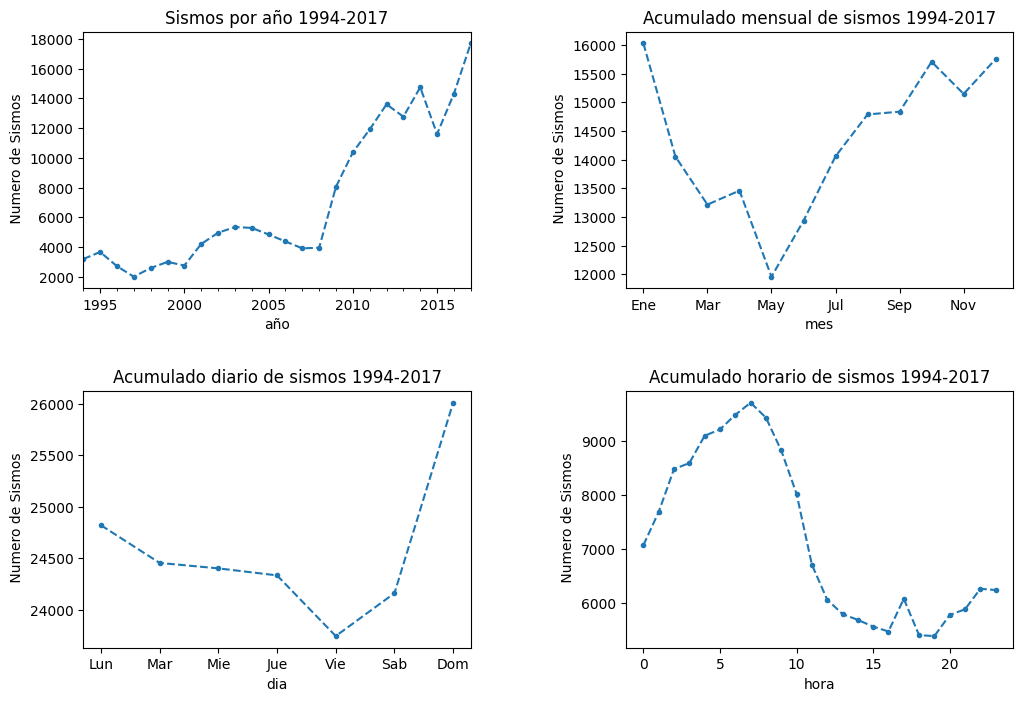

In [325]:
sismos_xmes = pd.to_datetime(sismos.FechaCompleta).dt.to_period(freq = 'M')
sismos_xmes = sismos_xmes.value_counts().sort_index()

sismos_xaño = pd.to_datetime(sismos.FechaCompleta).dt.to_period(freq = 'Y')
sismos_xaño = sismos_xaño.value_counts().sort_index()


sismosmes = sismos.Mes.value_counts().sort_index()
sismosmes.index = ['Ene','Feb','Mar','Abr','May','Jun', 'Jul','Ago','Sep','Oct','Nov','Dec']

sismosdia = sismos.Dia.value_counts().sort_index()
sismosdia.index = ['Lun','Mar','Mie','Jue','Vie','Sab','Dom']

sismoshora = sismos.hora.value_counts().sort_index()


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

#sismos_xmes.plot(marker='.', ls = '--', title = 'Sismos por Mes 1994-2017', ax=ax2).set(title='Points vs. Assists', xlabel = "ssss")
sismos_xaño.plot(marker='.', ls = '--', title = 'Sismos por año 1994-2017', ax=ax1).set(xlabel = "año", ylabel = " Numero de Sismos")
sismosmes.plot(marker='.', ls = '--', title = 'Acumulado mensual de sismos 1994-2017', ax=ax2).set(xlabel = "mes", ylabel = " Numero de Sismos")
sismosdia.plot(marker='.', ls = '--', title = 'Acumulado diario de sismos 1994-2017', ax=ax3).set(xlabel = "dia", ylabel = " Numero de Sismos")
sismoshora.plot(marker='.', ls = '--', title = 'Acumulado horario de sismos 1994-2017', ax=ax4).set(xlabel = "hora", ylabel = " Numero de Sismos")
#sismoshora.plot(marker='.', ls = '--', title = 'Acumulado horarios de sismos 1994-2017', ax=ax6).set(xlabel = "hora", ylabel = " Numero de Sismos")

plt.subplots_adjust(wspace=0.4,hspace=0.4)

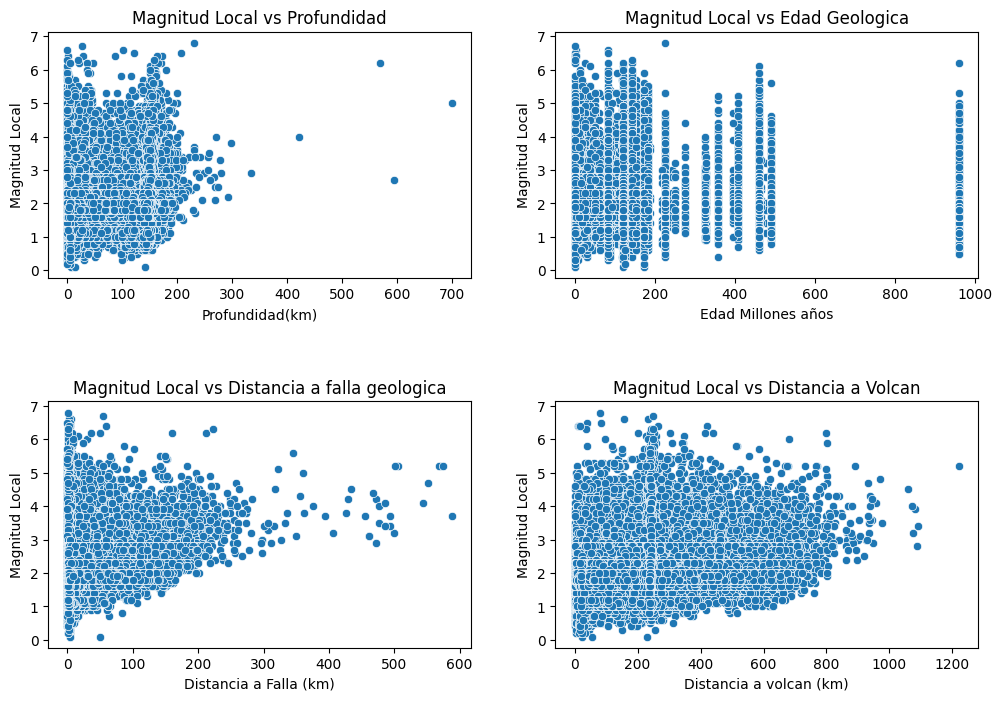

In [317]:


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

sns.scatterplot( data=sismos, x=sismos.Profundidad, y=sismos.Magnitud_ML, ax = ax1).set(title='Magnitud Local vs Profundidad', xlabel = "Profundidad(km)", ylabel = 'Magnitud Local')
sns.scatterplot( data=sismos, x=sismos.EdadMillAños, y=sismos.Magnitud_ML, ax = ax2).set(title='Magnitud Local vs Edad Geologica', xlabel = "Edad Millones años", ylabel = 'Magnitud Local')
sns.scatterplot( data=sismos, x=sismos.Disfalla, y=sismos.Magnitud_ML, ax = ax3).set(title='Magnitud Local vs Distancia a falla geologica', xlabel = "Distancia a Falla (km)", ylabel = 'Magnitud Local')
sns.scatterplot( data=sismos, x=sismos.Disvolcan, y=sismos.Magnitud_ML, ax = ax4).set(title='Magnitud Local vs Distancia a Volcan', xlabel = "Distancia a volcan (km)", ylabel = 'Magnitud Local')



plt.subplots_adjust(wspace=0.2,hspace=0.5)


<AxesSubplot: xlabel='Año', ylabel='Mes'>

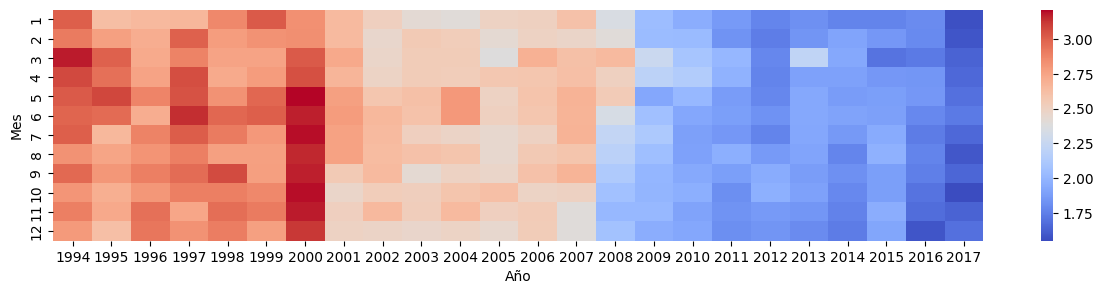

In [318]:
pivoted_df = pd.pivot_table(data=sismos, index="Mes", columns="Año", values="Magnitud_ML")

plt.figure(figsize=(15, 3)) # We can set the size using matplotlib
sns.heatmap(pivoted_df, cmap="coolwarm") # cmap defines the color palette

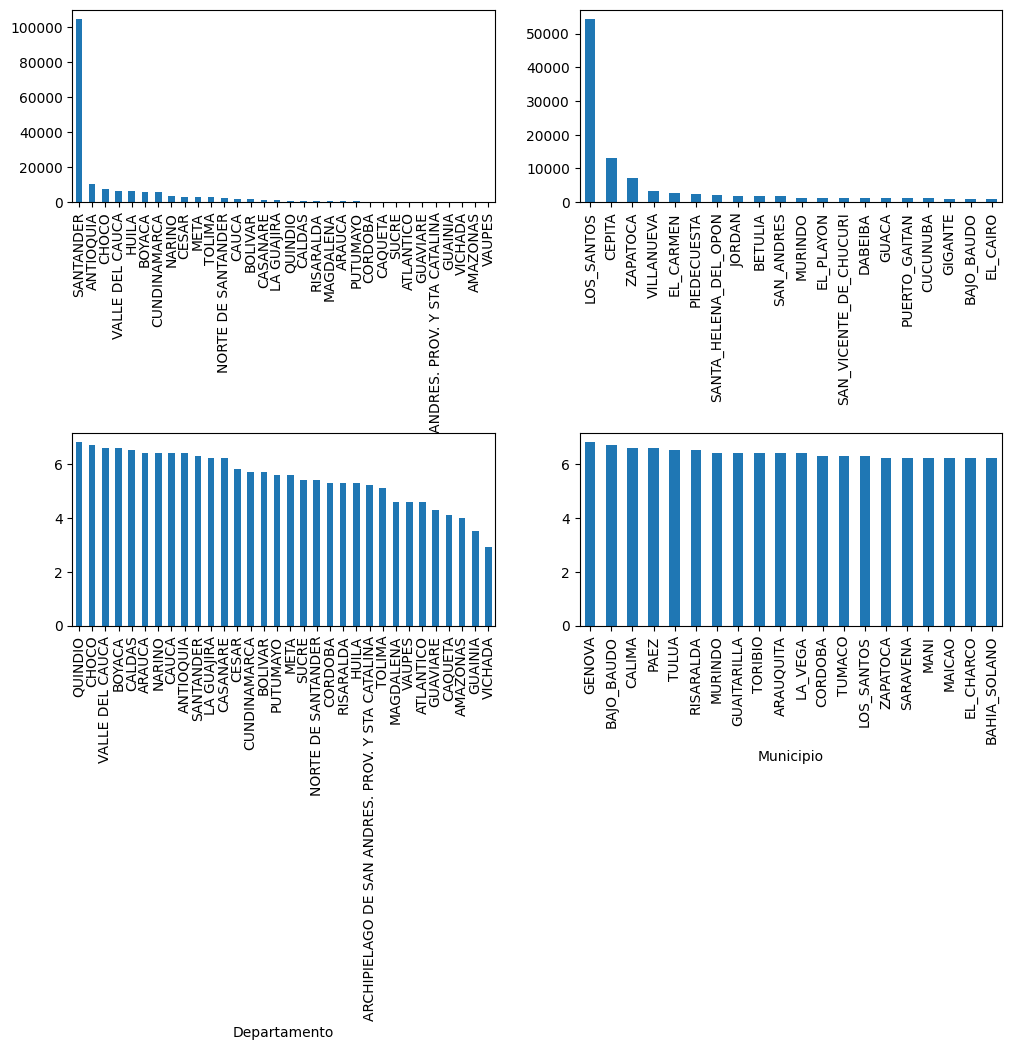

In [319]:


SismosDpto  = sismos.Departamento.value_counts()
SismosCountMpio  = sismos.Municipio.value_counts().sort_values(ascending=False).head(20)


sismosdpto = sismos.groupby(["Departamento"])["Magnitud_ML"].max().sort_values(ascending=False)
sismosMpio = sismos.groupby(["Municipio"])["Magnitud_ML"].max().sort_values(ascending=False).head(20)


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sismosdpto.plot.bar(ax = ax3)
SismosDpto.plot.bar(ax = ax1)
sismosMpio.plot.bar(ax = ax4)
SismosCountMpio.plot.bar(ax = ax2)

plt.subplots_adjust(wspace=0.2,hspace=1.2)


In [320]:
sismosMpio

Municipio
GENOVA          6.8
BAJO_BAUDO      6.7
CALIMA          6.6
PAEZ            6.6
TULUA           6.5
RISARALDA       6.5
MURINDO         6.4
GUAITARILLA     6.4
TORIBIO         6.4
ARAUQUITA       6.4
LA_VEGA         6.4
CORDOBA         6.3
TUMACO          6.3
LOS_SANTOS      6.3
ZAPATOCA        6.2
SARAVENA        6.2
MANI            6.2
MAICAO          6.2
EL_CHARCO       6.2
BAHIA_SOLANO    6.2
Name: Magnitud_ML, dtype: float64

In [321]:
sispro = pd.DataFrame((pd.DataFrame(SismosDpto)/ len(sismos.index))*100)
sispro

,Departamento
SANTANDER,60.772099
ANTIOQUIA,6.120835
CHOCO,4.289179
VALLE DEL CAUCA,3.815124
HUILA,3.541161
BOYACA,3.432390
CUNDINAMARCA,3.362009
NARINO,2.139355
CESAR,1.853758
META,1.785704


In [322]:
sismosaño = sismos.groupby(["Departamento", "Año"])["Magnitud_ML"].max()
sismosaño

Departamento  Año 
AMAZONAS      1998    4.0
              2012    3.2
ANTIOQUIA     1994    6.4
              1995    5.1
              1996    5.4
                     ... 
VAUPES        2011    2.6
VICHADA       1998    2.8
              2010    2.9
              2013    2.5
              2014    2.5
Name: Magnitud_ML, Length: 649, dtype: float64

<AxesSubplot: xlabel='Departamento', ylabel='Año'>

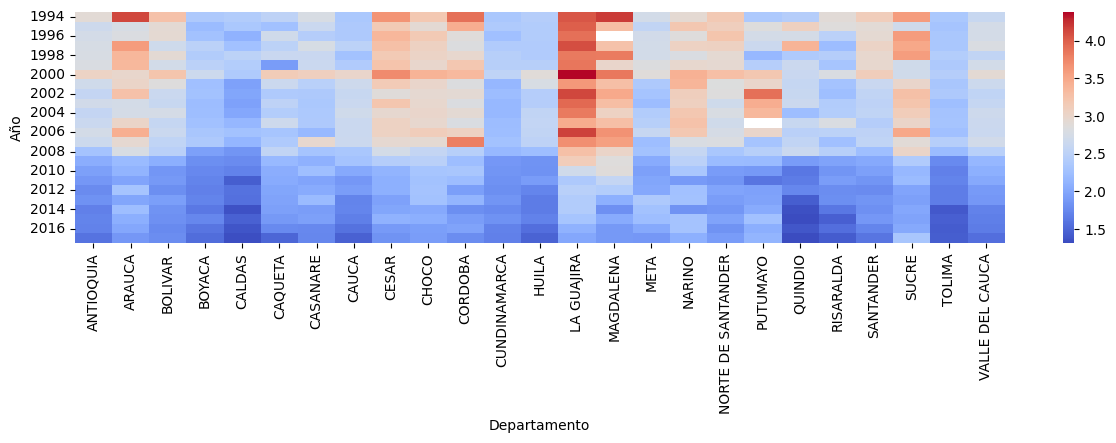

In [326]:
pivoted_df2 = pd.pivot_table(data=sismos, index="Año", columns="Departamento", values="Magnitud_ML")
pivoted_df2 = pivoted_df2.drop(columns=['ARCHIPIELAGO DE SAN ANDRES. PROV. Y STA CATALINA', 'GUAINIA', 'VAUPES','VICHADA', 'AMAZONAS', 'GUAVIARE', 'ATLANTICO'])

plt.figure(figsize=(15, 3)) # We can set the size using matplotlib
sns.heatmap(pivoted_df2, cmap="coolwarm") # cmap defines the color palet